<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-разделу" data-toc-modified-id="Вывод-по-разделу-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод по разделу</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-разделу" data-toc-modified-id="Вывод-по-разделу-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод по разделу</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-дополнительных-признаков" data-toc-modified-id="Создание-дополнительных-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание дополнительных признаков</a></span></li><li><span><a href="#Подготовка-датасетов-к-обучению-модели" data-toc-modified-id="Подготовка-датасетов-к-обучению-модели-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подготовка датасетов к обучению модели</a></span></li><li><span><a href="#Модель-DecisionTreeRegressor" data-toc-modified-id="Модель-DecisionTreeRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель DecisionTreeRegressor</a></span></li><li><span><a href="#Модель-RandomForestRegressor" data-toc-modified-id="Модель-RandomForestRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель RandomForestRegressor</a></span></li><li><span><a href="#Модель-CatBoostRegressor" data-toc-modified-id="Модель-CatBoostRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Модель CatBoostRegressor</a></span></li><li><span><a href="#Модель-LGBMRegressor" data-toc-modified-id="Модель-LGBMRegressor-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Модель LGBMRegressor</a></span></li><li><span><a href="#Вывод-по-разделу" data-toc-modified-id="Вывод-по-разделу-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Вывод по разделу</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
!pip install scikit-learn==1.1.3

In [2]:
# Импортируем все необходимы библиотеки
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Зафиксируем константные значения
RANDOM_STATE=12345

## Подготовка

Подгрузим датасет, посмотрим на общую информацию по датасету, проверим данные на наличие пропусков, проверим на хроноологичность данных

In [3]:
# Подгрузим данные и сохраним в переменной
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
# Проверим в хронологическом порядке ли расположены дата и время
data.index.is_monotonic

True

In [7]:
# Сделаем ресемплирование датасета по одному часу
data_1h = data.resample('1H').sum()
data_1h.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
# Посмотрим во сколько раз изменился размер датасета
data.shape[0] / data_1h.shape[0]

6.0

### Вывод по разделу

В ходе подготовки данных были подгружены и сохранены данные в переменную, ознакомились с общей информаций по датасету.

Провели ресемплирование данных по 1 часу т.к. не нужен очень детальный прогноз до 10 минут, будем делать прогноз для каждого часа.

## Анализ

Проанализируем данные, посмотрим на тренды и сезонность, построим графики, также посмотрим как меняется среднее количество заказов в течение суток и в течении недели.

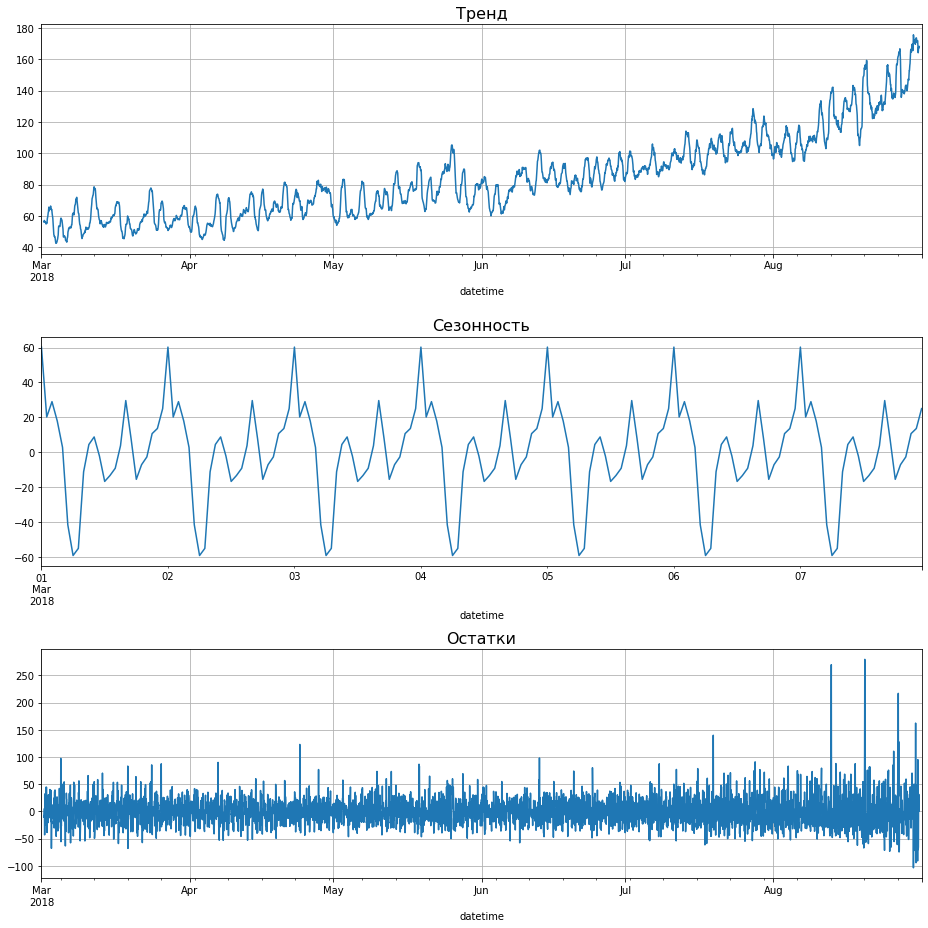

In [9]:
# Оценим тренды и сезонность в данных
decomposed = seasonal_decompose(data_1h['num_orders'])

plt.figure(figsize=(13, 13))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), grid=True)
plt.title('Тренд', fontsize=16)
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca(), grid=True)
plt.title('Сезонность', fontsize=16)
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), grid=True)
plt.title('Остатки', fontsize=16)
plt.tight_layout()

Исходя из графиков можно сделать следующий вывод:
1. Cудя по тренду мы видим рост количества заказов такси более чем в 3 раза, но нельзя сказать связано ли это с временем года т.к. выборка не достаточна для этого, неоходимо хотя бы два года, возможно такой плавный рост связан с ростом популярности этого оператора (компании) такси.
2. На графике сезонности видна переодичность заказов в течении недели.
3. Остатки в основном от -50 до 50 

**Посмотрим на зависимость заказов такси от времени суток и дня недели**

In [10]:
# Функция создания дополнительных признаков из datetime
def make_features(data):
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour

In [11]:
make_features(data_1h)
data_1h.head()

,num_orders,day,day_of_week,hour
datetime,,,,
2018-03-01 00:00:00,124,1,3,0
2018-03-01 01:00:00,85,1,3,1
2018-03-01 02:00:00,71,1,3,2
2018-03-01 03:00:00,66,1,3,3
2018-03-01 04:00:00,43,1,3,4


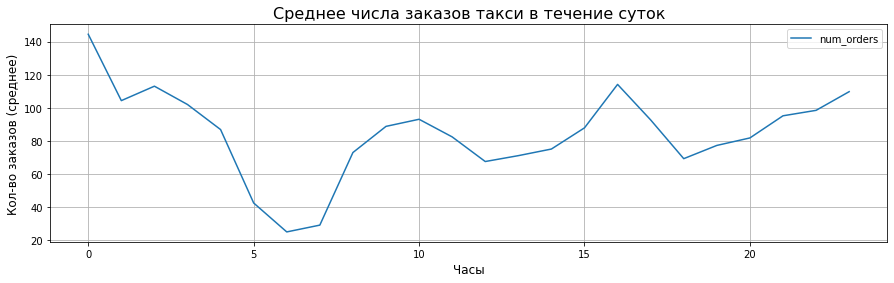

In [12]:
# Оценим как, в среденем меняется количество заказов в течение суток
data_1h.pivot_table(index='hour', 
                    values='num_orders', 
                    aggfunc='mean').plot(grid=True,
                                         figsize=(15, 4))
plt.title('Среднее числа заказов такси в течение суток', fontsize=16)
plt.xlabel('Часы', fontsize=12)
plt.ylabel('Кол-во заказов (среднее)', fontsize=12)
plt.show()

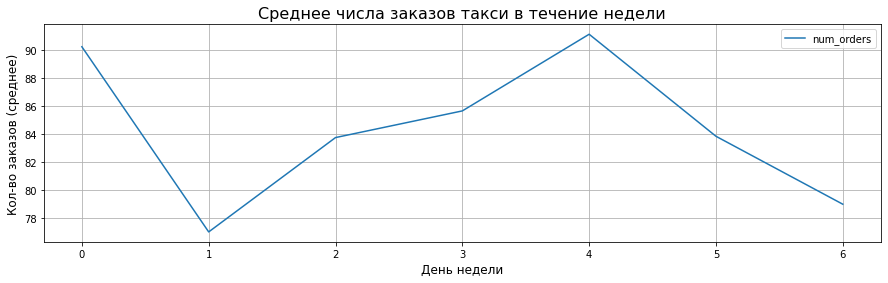

In [13]:
# Оценим как, в среденем меняется количество заказов в течение недели
data_1h.pivot_table(index='day_of_week', 
                    values='num_orders', 
                    aggfunc='mean').plot(grid=True,
                                         figsize=(15, 4))
plt.title('Среднее числа заказов такси в течение недели', fontsize=16)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Кол-во заказов (среднее)', fontsize=12)
plt.show()

Из графиков видно:
1. **График среднего числа заказов в течение суток**. Ранним утром 5:00 - 7:00 наименьшее количество заказов такси, далее с 7:00 - 10:00 рост числа заказов (когда люди едут на работу), наибольшее количесиво заказов, примерно с 22:00 - 00:00, далее в течение ночи количество заказов снижается.
2. **График среднего числа заказо в течение недели**. Наибольшее количество заказов в понедельник и в пяницу, наименьшее во вторник и воскресенье. Со вторника по пятницу виден рост числа заказов, с пяницу по воскресенье падение числа заказов.

### Вывод по разделу
После проведения анализа данных было выявлено:
1. Наблюдается тренд на рост числа заказов с течением времени.
2. Выявлена сезонность заказов такси. Циклично повторяются закономерности заказов такси ежесуточно.
3. Наименьшее число заказов такси в течение суток в период 5:00 - 7:00, наибольшее - 22:00 - 00:00
4. Наименьшее число заказов такси в течение недели во вторник, наибольшее в пяницу и в понедельник.

## Обучение

Выделим целевой признак из данных. Разобъем данные на тренировочную, валидационную и тестовую выборки. Обучим несколько моделей машинного обучения и выберем наилучшую модель.

### Создание дополнительных признаков

В связи с тем, что сезонность наблюдается с переодичностью в одни сутки, максимальное количество лагов будет равно 24 для прогнозирования числа заказов для каждого часа. 

Создадим два столбца rolling_mean_size, первый с разбивкой по 6 часов, т.к видно, что утром, днем, вечером и ночью количество заказов изменяется, второй с разбивкой по 24 часа, т.к. в зависимости от дня недели число заказов тоже изменяется.

In [15]:
# Создадим лаги в датасете
for lag in range(1, 25):
    data_1h[f'lag_{lag}'] = data_1h['num_orders'].shift(lag)
    
data_1h['lag_168'] = data_1h['num_orders'].shift(168)

In [16]:
# Создадим признаки rolling_mean_size
data_1h['rolling_mean_6h'] = data_1h['num_orders'].shift().rolling(6).mean()
#data_1h['rolling_mean_day'] = data_1h['num_orders'].shift().rolling(24).mean()

In [17]:
data_1h.dropna(inplace=True)
data_1h.head()

,num_orders,day,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_168,rolling_mean_6h
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,8,3,0,94.0,127.0,108.0,76.0,50.0,99.0,...,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,124.0,92.333333
2018-03-08 01:00:00,78,8,3,1,143.0,94.0,127.0,108.0,76.0,50.0,...,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,85.0,99.666667
2018-03-08 02:00:00,65,8,3,2,78.0,143.0,94.0,127.0,108.0,76.0,...,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,71.0,104.333333
2018-03-08 03:00:00,68,8,3,3,65.0,78.0,143.0,94.0,127.0,108.0,...,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,66.0,102.500000
2018-03-08 04:00:00,60,8,3,4,68.0,65.0,78.0,143.0,94.0,127.0,...,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,43.0,95.833333


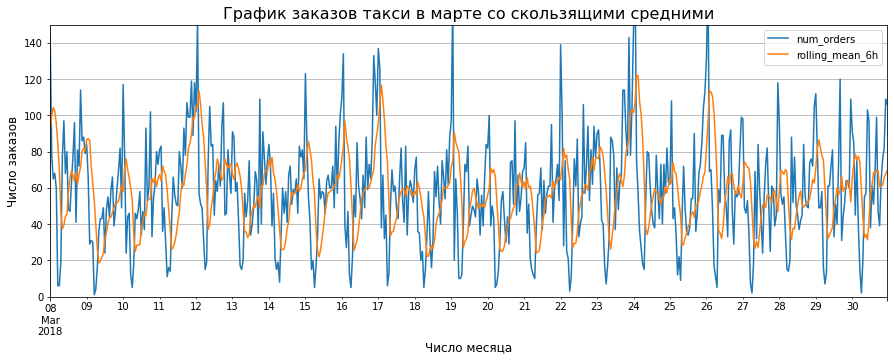

In [18]:
data_1h['2018-03-01':'2018-03-30'].plot(y=['num_orders', 'rolling_mean_6h'], 
                                  figsize=(15, 5),
                                  grid=True);
plt.title('График заказов такси в марте со скользящими средними', fontsize=16)
plt.xlabel('Число месяца', fontsize=12)
plt.ylabel('Число заказов', fontsize=12)
plt.ylim(0, 150)
plt.show()

### Подготовка датасетов к обучению модели

In [19]:
# Разделим данные на обучающую и тестовую выборки
train, test = train_test_split(data_1h, 
                               test_size=0.1, 
                               shuffle=False)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-08 00:00:00 2018-08-14 06:00:00
2018-08-14 07:00:00 2018-08-31 23:00:00


In [20]:
# Разделим датасеты на обучающие признаки и целевой признак
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_train.shape[0] / X_test.shape[0]

(3823, 29) (3823,)
(425, 29) (425,)


8.99529411764706

### Модель DecisionTreeRegressor

In [21]:
tscv = TimeSeriesSplit(n_splits=5)

In [22]:
dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)
param_grid_dtr = {'max_depth': range(1, 11, 1),
                  'splitter': ('best', 'random'),
                  'min_samples_split': range(2, 11, 1)
                }
grid_search_dtr = RandomizedSearchCV(estimator=dtr,
                                     cv=tscv,
                                     param_distributions=param_grid_dtr,
                                     n_jobs=-1,
                                     random_state=RANDOM_STATE,
                                     scoring='neg_root_mean_squared_error')

dtr_pred = grid_search_dtr.fit(X_train, y_train)

In [23]:
print(f'''
Лучшая оценка RMSE: {dtr_pred.best_score_ * -1}
Лучшие параметры модели: {dtr_pred.best_params_}
''')


Лучшая оценка RMSE: 26.399166033977565
Лучшие параметры модели: {'splitter': 'random', 'min_samples_split': 10, 'max_depth': 7}



### Модель RandomForestRegressor

In [24]:
rfr = RandomForestRegressor(random_state=RANDOM_STATE)
param_grid_rfr = {'max_depth': range(1, 11, 1),
                  'n_estimators': range(10, 101, 10),
                  'min_samples_split': range(2, 11, 1)
                }
grid_search_rfr = RandomizedSearchCV(estimator=rfr,
                                     param_distributions=param_grid_rfr,
                                     n_jobs=-1,
                                     random_state=RANDOM_STATE,
                                     cv=tscv,
                                     scoring='neg_root_mean_squared_error')

rfr_pred = grid_search_rfr.fit(X_train, y_train)

In [25]:
print(f'''
Лучшая оценка RMSE: {rfr_pred.best_score_ * -1}
Лучшие параметры модели: {rfr_pred.best_params_}
''')


Лучшая оценка RMSE: 23.377509141827698
Лучшие параметры модели: {'n_estimators': 90, 'min_samples_split': 8, 'max_depth': 9}



### Модель CatBoostRegressor

In [26]:
cat_features = ['day',
                'day_of_week',
                'hour']

In [27]:
cbr = CatBoostRegressor(random_state=RANDOM_STATE,
                        logging_level = 'Silent',
                        cat_features=cat_features,
                        loss_function='RMSE')

param_grid_cbr = {'max_depth': range(1, 6, 1),
                  'n_estimators': range(10, 200, 10),
                  'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2]}

grid_search_cbr = cbr.randomized_search(param_grid_cbr,
                                        X=X_train,
                                        y=y_train,
                                        cv=tscv,
                                        refit=True)

0:	loss: 29.0767149	best: 29.0767149 (0)	total: 1.8s	remaining: 16.2s
1:	loss: 29.6058014	best: 29.0767149 (0)	total: 1.85s	remaining: 7.4s
2:	loss: 30.0062099	best: 29.0767149 (0)	total: 2.1s	remaining: 4.9s
3:	loss: 30.5051014	best: 29.0767149 (0)	total: 2.46s	remaining: 3.68s
4:	loss: 46.0532233	best: 29.0767149 (0)	total: 2.83s	remaining: 2.83s
5:	loss: 29.9036783	best: 29.0767149 (0)	total: 2.93s	remaining: 1.95s
6:	loss: 33.1069371	best: 29.0767149 (0)	total: 3.15s	remaining: 1.35s


learning rate is greater than 1. You probably need to decrease learning rate.


7:	loss: 52.8499134	best: 29.0767149 (0)	total: 3.71s	remaining: 927ms
8:	loss: 29.6022840	best: 29.0767149 (0)	total: 4.5s	remaining: 500ms
9:	loss: 29.0327697	best: 29.0327697 (9)	total: 5.43s	remaining: 0us
Estimating final quality...


In [28]:
print(f'Лучшая оценка: {cbr.best_score_}')

Лучшая оценка: {'learn': {'RMSE': 17.79390780708966}}


### Модель LGBMRegressor

In [29]:
lgbmr = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1)

param_grid_lgbmr = {'max_depth': range(1, 6, 1),
                    'n_estimators': range(10, 200, 10),
                    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2]}

grid_search_lgbmr = RandomizedSearchCV(estimator=lgbmr,
                                       param_distributions=param_grid_lgbmr,
                                       n_jobs=-1,
                                       random_state=RANDOM_STATE,
                                       cv=tscv,
                                       scoring='neg_root_mean_squared_error')

lgbmr_pred = grid_search_lgbmr.fit(X_train, y_train)

In [30]:
print(f'''
Лучшая оценка RMSE: {lgbmr_pred.best_score_ * -1}
Лучшие параметры модели: {lgbmr_pred.best_params_}
''')


Лучшая оценка RMSE: 22.951854318981976
Лучшие параметры модели: {'n_estimators': 90, 'max_depth': 3, 'learning_rate': 0.1}



### Вывод по разделу

В ходе раздела было выполнено:
1. Созданы дополнительные признаки - лаги
2. Созданы дополнительные признаки - `rolling_mean_6h` и `rolling_mean_day`
3. Подготовлены датасеты к обучению моделей
4. Обучены модели DecisionTreeRegressor, RandomForestRegressor, CatBoostRegressor и LGBMRegressor

Наилучшей оказалась модель **CatBoostRegressor** значение **RMSE - 17.79**

## Тестирование

In [31]:
# Протестируем выбранную модель на тестовых данных
predictions_cbr = cbr.predict(X_test)
print(f'RMSE для модели CatBoostRegressor: {mean_squared_error(y_test,predictions_cbr) ** 0.5}')

RMSE для модели CatBoostRegressor: 39.895131769194556


In [32]:
# Сравним с предсказаниями предыдущего значения ряда
pred_previous = y_test.shift().fillna(y_train[-1])
print(f'RMSE для предыдущего значения ряда: {mean_squared_error(y_test, pred_previous) ** 0.5}')

RMSE для предыдущего значения ряда: 58.819724582830204


RMSE для предыдущего значения ряда получилось больше, чем RMSE для модели CatBoostRegressor.

## Вывод

В ходе работы:
1. Подгрузили данные и ознакомились с общей информацией, провели ресемлирование датасета по 1 часу.
2. Провели разведочный анализ данных. Был выявлен тренд на рост числа заказов такси и выявлена сезонность заказов такси (еженевная)
3. Были созданы дополнительные признаки в датасете
4. Выявлены закономерности числа заказов такси в зависимости от времени суток и дня недели.
5. Провели обучение моделей регресии

Наилучшей моделью оказалась модель **CatBoostRegressor**, значением **RMSE** на тестовых данных - **39.89**